# F1 statistics & simulation

## Introduction

Credit:
The original version of this notebook was created by David Chevrier, Diggers.

More information: https://www.diggers-consulting.com/blog/articles/how-data-science-could-turn-felipe-massa-a-f1-world-champion

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=formula-one" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover.png" alt="Try atoti"></a></div>

## Dataset
Data from https://ergast.com/mrd/db/#csv
F1 data from 1950 to 2019

## Initialization & creation of the atoti session

In [1]:
import numpy as np
import pandas as pd
import atoti as tt

session = tt.create_session()

## Creation of the stores

In [2]:
drivers_df = pd.read_csv(
    "https://data.atoti.io/notebooks/formula-one/drivers.csv", encoding="latin-1"
)
drivers_df.rename(columns={"url": "driver_url"}, inplace=True)
drivers_df.rename(columns={"nationality": "driver_nationality"}, inplace=True)

drivers_store = session.read_pandas(
    drivers_df, keys=["driverId"], store_name="F1 drivers"
)

In [3]:
races_df = pd.read_csv(
    "https://data.atoti.io/notebooks/formula-one/races.csv", encoding="latin-1"
)
races_df.rename(columns={"url": "race_url"}, inplace=True)
races_df.rename(columns={"name": "race_name"}, inplace=True)

races_store = session.read_pandas(
    races_df, keys=["raceId"], store_name="F1 races", types={"year": tt.type.STRING}
)

In [4]:
constructors_df = pd.read_csv(
    "https://data.atoti.io/notebooks/formula-one/constructors.csv", encoding="latin-1"
)
constructors_df.rename(columns={"url": "constructor_url"}, inplace=True)
constructors_df.rename(columns={"name": "constructor_name"}, inplace=True)
constructors_df.rename(columns={"nationality": "constructor_nationality"}, inplace=True)

constructors_store = session.read_pandas(
    constructors_df,
    keys=["constructorId"],
    store_name="F1 constructors",
)

In [5]:
results_df = pd.read_csv("https://data.atoti.io/notebooks/formula-one/results.csv")
results_df.loc[results_df["fastestLapSpeed"] == "\\N", "fastestLapSpeed"] = None
results_df.loc[results_df["position"] == "\\N", "position"] = None

resultsTypes = {
    "points": tt.type.DOUBLE,
    "position": tt.type.INT,
    "resultId": tt.type.STRING,
}

results_store = session.read_pandas(
    results_df,
    keys=["resultId"],
    store_name="F1 results",
    types=resultsTypes,
)

The store has been sampled because there are more than 10000 lines in the files to load and the appended lines. Call Session.load_all_data() to trigger the full load of the data.


In [6]:
results_store.join(drivers_store, mapping={"driverId": "driverId"})
results_store.join(races_store, mapping={"raceId": "raceId"})
results_store.join(constructors_store, mapping={"constructorId": "constructorId"})

## Cube

In [7]:
f1cube = session.create_cube(results_store, "F1Cube")

In [8]:
# We can now load all the data so that visualizations operate on the entire dataset.
# NB: as a best practice, to optimize speed while exploring your data, we recommend keeping the default sampling mode enabled.
#     Once the model is ready, as it is the case in this notebook, you may call session.load_all_data() after creating the cube.
session.load_all_data()

6 error(s) occurred while feeding the store F1 results. Check the store's loading_report for more details.


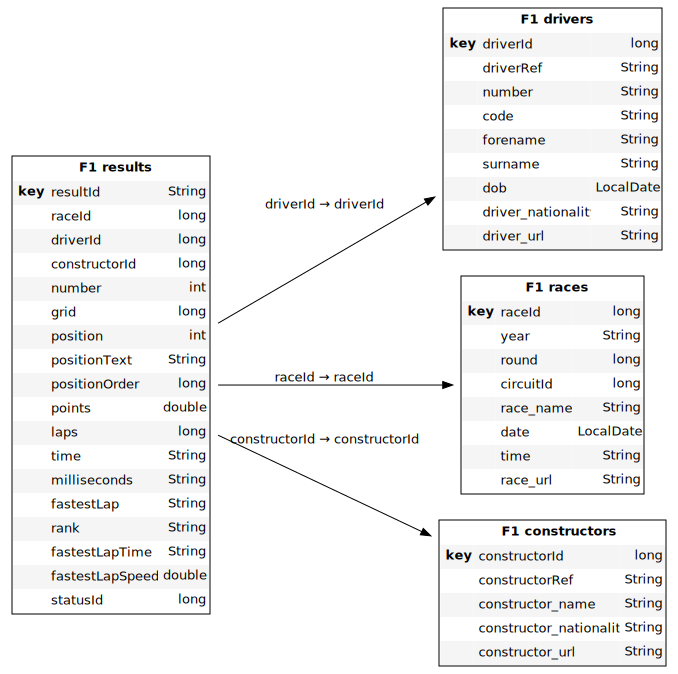

In [9]:
f1cube.schema

In [10]:
lvl = f1cube.levels
m = f1cube.measures
h = f1cube.hierarchies

## Analysis

### Driver with the most races

Barichello has cumulated more than 326 races over his career!

In [11]:
session.visualize("Total number of races per driver")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

### Fastest drivers



In [12]:
m["fastestLapSpeed.MIN"] = tt.agg.min(results_store["fastestLapSpeed"])

m["Fastest driver"] = tt.where(
    m["fastestLapSpeed.MIN"] != None,
    tt.agg.min_member(m["fastestLapSpeed.MIN"], lvl["driverRef"]),
)
m["Fastest year"] = tt.where(
    m["fastestLapSpeed.MIN"] != None,
    tt.agg.min_member(m["fastestLapSpeed.MIN"], lvl["year"]),
)

In [13]:
session.visualize()

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

### Top driver and constructors

Let's create some measures to return the driver and constructor with the most points.

In [14]:
m["Score"] = m["points.SUM"]
m["Top driver"] = tt.agg.max_member(m["Score"], lvl["driverRef"])
m["Top constructor"] = tt.agg.max_member(m["Score"], lvl["constructor_name"])

In [15]:
session.visualize("Top driver by year")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [16]:
session.visualize("Top constructor by year")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

Lewis Hamilton and it's team Mercedes have been dominating the championship for almost the last 6 years.

Let's compare driver's scores:

In [17]:
session.visualize("Score per drivers")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

Hamilton is the driver with the most points ever. However, it's unfair to compare points accross seasons since the scoring systems are not constant and most recent seasons award more points to drivers. This explains why pilots like Hamilton and Vettel have much more points than Schumacher while having ran and scored less races.

### Different scoring systems

Scoring rules for Formula One have [changed over time](https://en.wikipedia.org/wiki/List_of_Formula_One_World_Championship_points_scoring_systems). To make a fair comparison, let's normalize the points across all years by applying a constant scoring across all seasons.

First, we'll determine the maximum position across all seasons:

In [18]:
m["position.MAX"] = tt.agg.max(results_store["position"])

In [19]:
maxPositionDf = f1cube.query(m["position.MAX"])
maxPositionDf

,position.MAX
0,33


This means that there has never been more than 33 drivers in one race. We'll use that information to create a data frame representing the different points awarded by positions across all scoring system:

In [20]:
# index = scoring systen
scoring_systems = [
    "Scoring 1950 to 1953",
    "Scoring 1954 to 1957 & 1959",
    "Scoring 1958",
    "Scoring 1960",
    "Scoring 1961 to 1962 & 1966",
    "Scoring 1963 to 1965",
    "Scoring 1967 & 1969 & 1971",
    "Scoring 1968 & 1972",
    "Scoring 1970",
    "Scoring 1973 to 1974",
    "Scoring 1975",
    "Scoring 1976 & 1978",
    "Scoring 1977",
    "Scoring 1979",
    "Scoring 1980",
    "Scoring 1981 to 1990",
    "Scoring 1991 to 2002",
    "Scoring 2003 to 2009",
    "Scoring 2010 to 2020",
]

In [21]:
scoring_positions = np.arange(1, maxPositionDf["position.MAX"][0] + 1)
# a column for each position
# values = number of points scored for this year's race position
dfscoring = pd.DataFrame(
    0,
    index=scoring_systems,
    columns=scoring_positions,
)

dfscoring.loc["Scoring 1950 to 1953"][1, 2, 3, 4, 5] = [8, 6, 4, 3, 2]
dfscoring.loc["Scoring 1954 to 1957 & 1959"] = dfscoring.loc["Scoring 1950 to 1953"]
dfscoring.loc["Scoring 1958"] = dfscoring.loc["Scoring 1950 to 1953"]

dfscoring.loc["Scoring 1960"][1, 2, 3, 4, 5, 6] = [8, 6, 4, 3, 2, 1]

dfscoring.loc["Scoring 1961 to 1962 & 1966"][1, 2, 3, 4, 5, 6] = [9, 6, 4, 3, 2, 1]
dfscoring.loc["Scoring 1967 & 1969 & 1971"] = dfscoring.loc[
    "Scoring 1961 to 1962 & 1966"
]
dfscoring.loc["Scoring 1968 & 1972"] = dfscoring.loc["Scoring 1961 to 1962 & 1966"]
dfscoring.loc["Scoring 1970"] = dfscoring.loc["Scoring 1961 to 1962 & 1966"]
dfscoring.loc["Scoring 1973 to 1974"] = dfscoring.loc["Scoring 1961 to 1962 & 1966"]
dfscoring.loc["Scoring 1975"] = dfscoring.loc["Scoring 1961 to 1962 & 1966"]
dfscoring.loc["Scoring 1976 & 1978"] = dfscoring.loc["Scoring 1961 to 1962 & 1966"]
dfscoring.loc["Scoring 1977"] = dfscoring.loc["Scoring 1961 to 1962 & 1966"]
dfscoring.loc["Scoring 1979"] = dfscoring.loc["Scoring 1961 to 1962 & 1966"]
dfscoring.loc["Scoring 1980"] = dfscoring.loc["Scoring 1961 to 1962 & 1966"]
dfscoring.loc["Scoring 1981 to 1990"] = dfscoring.loc["Scoring 1961 to 1962 & 1966"]

dfscoring.loc["Scoring 1991 to 2002"][1, 2, 3, 4, 5, 6] = [10, 6, 4, 3, 2, 1]

dfscoring.loc["Scoring 2003 to 2009"][1, 2, 3, 4, 5, 6, 7, 8] = [
    10,
    8,
    6,
    5,
    4,
    3,
    2,
    1,
]

# FIXME 2014 + fastlap 2019+
dfscoring.loc["Scoring 2010 to 2020"][1, 2, 3, 4, 5, 6, 7, 8, 9, 10] = [
    25,
    18,
    15,
    12,
    10,
    8,
    6,
    4,
    2,
    1,
]

In [22]:
dfscoring

,1,2,3,4,5,6,7,8,9,10,...,24,25,26,27,28,29,30,31,32,33
Scoring 1950 to 1953,8,6,4,3,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Scoring 1954 to 1957 & 1959,8,6,4,3,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Scoring 1958,8,6,4,3,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Scoring 1960,8,6,4,3,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Scoring 1961 to 1962 & 1966,9,6,4,3,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Scoring 1963 to 1965,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Scoring 1967 & 1969 & 1971,9,6,4,3,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Scoring 1968 & 1972,9,6,4,3,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Scoring 1970,9,6,4,3,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Scoring 1973 to 1974,9,6,4,3,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
dfbestresult = pd.DataFrame(
    0,
    index=scoring_systems,
    columns=["Best result"],
)

dfbestresult.loc["Scoring 1950 to 1953"] = 4
dfbestresult.loc["Scoring 1954 to 1957 & 1959"] = 5
dfbestresult.loc["Scoring 1958"] = 6
dfbestresult.loc["Scoring 1960"] = 6
dfbestresult.loc["Scoring 1961 to 1962 & 1966"] = 5
dfbestresult.loc["Scoring 1963 to 1965"] = 6

# FIXME
dfbestresult.loc["Scoring 1967 & 1969 & 1971"] = 9
dfbestresult.loc["Scoring 1968 & 1972"] = 10
dfbestresult.loc["Scoring 1970"] = 11
dfbestresult.loc["Scoring 1973 to 1974"] = 13
dfbestresult.loc["Scoring 1975"] = 12
dfbestresult.loc["Scoring 1976 & 1978"] = 14
dfbestresult.loc["Scoring 1977"] = 15
dfbestresult.loc["Scoring 1979"] = 8
dfbestresult.loc["Scoring 1980"] = 10

dfbestresult.loc["Scoring 1981 to 1990"] = 11
dfbestresult.loc["Scoring 1991 to 2002"] = 1000
dfbestresult.loc["Scoring 2003 to 2009"] = 1000
dfbestresult.loc["Scoring 2010 to 2020"] = 1000

In [24]:
dfbestresult

,Best result
Scoring 1950 to 1953,4
Scoring 1954 to 1957 & 1959,5
Scoring 1958,6
Scoring 1960,6
Scoring 1961 to 1962 & 1966,5
Scoring 1963 to 1965,6
Scoring 1967 & 1969 & 1971,9
Scoring 1968 & 1972,10
Scoring 1970,11
Scoring 1973 to 1974,13


### Score implementation

In [25]:
m["Best results"] = 1000
m["Result Rank"] = tt.rank(m["points.SUM"], h["race_name"], ascending=False)
m["Score"] = tt.agg.sum(
    tt.where(m["Result Rank"] <= m["Best results"], m["points.SUM"], 0),
    scope=tt.scope.origin(lvl["race_name"]),
)

### Simulations

Using the dataframe created before, we'll setup one simulation per scoring system:

In [26]:
# Creation of simulation
pointssystem_sim = f1cube.setup_simulation(
    "pointssystem_sim",
    levels=[lvl["positionText"], lvl["resultId"]],
    replace=[m["points.SUM"], m["Best results"]],
    base_scenario="Base",
)

6 error(s) occurred while feeding the store F1 results. Check the store's loading_report for more details.


In [27]:
# Feed of the different scenarios with points from related scoring systems
for scoring_name in scoring_systems:
    simulated_best_results = float(dfbestresult.loc[scoring_name])
    for i in scoring_positions:
        simulated_points = float(dfscoring.loc[scoring_name][i])
        pointssystem_sim.scenarios[scoring_name] += (
            str(i),
            None,
            simulated_points,
            simulated_best_results,
        )

In [28]:
# Example of scoring scenario
pointssystem_sim.scenarios["Scoring 1980"].head(10)

,,pointssystem_sim_points.SUM_replace,pointssystem_sim_Best results_replace,Priority
positionText,resultId,,,
1.0,NaN,9.0,10.0,0.0
2.0,NaN,6.0,10.0,0.0
3.0,NaN,4.0,10.0,0.0
4.0,NaN,3.0,10.0,0.0
5.0,NaN,2.0,10.0,0.0
6.0,NaN,1.0,10.0,0.0
7.0,NaN,0.0,10.0,0.0
8.0,NaN,0.0,10.0,0.0
9.0,NaN,0.0,10.0,0.0


In [29]:
session.visualize("Top driver by year across scenarios")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

In [30]:
# Apply conditional formatting via MDX
#  Member [Measures].[Top driver (1)] AS [Measures].[Top driver], FORE_COLOR = iif(
#   [Measures].[Top driver] <> (
#     [Measures].[Top driver],
#     [Measure Simulations].[pointssystem_sim].[pointssystem_sim].[Base]
#   ),
#   "red",
#   NULL
# )
session.visualize("Champion comparison")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

### Showing the differences for the race result of a famous GP, Brazil 2008
Where we see how the 1991-2002 scoring systems makes a big difference between chamionship rivals Massa & Hamilton
See race summary here: https://www.youtube.com/watch?v=XHSeGou-pCI ;)

In [31]:
session.visualize("Base vs. Simulation - Brazil 2008")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

### Showing the differences for the 2008 world championship result
Would Felipe Massa have become world champ in 2008 with the 1991-2002 scoring system?? YES!

In [32]:
session.visualize("Base vs. Simulation System 1991 to 2002 - 2008 Championship")

Open the notebook in JupyterLab with the atoti extension installed and enabled to start editing this widget.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=formula-one" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/discover-try.png" alt="Try atoti"></a></div>